## Microsoft Building Footprints Example

Bing Maps is releasing open building footprints around the world. The building footprints are detected using Bing Maps imagery between 2014 and 2021 including Maxar and Airbus imagery. The data is freely available for download and use under ODbL.

In [1]:
import geopandas
import planetary_computer
import pystac_client
import dask.dataframe
import dask_geopandas
import dask.distributed
import shapely.geometry
import contextily

### Querying the STAC API

The files are available as a set of GeoParquet datasets. There's one parquet datsaet per region.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
items = catalog.search(
    collections=["ms-buildings"], query={"msbuildings:region": {"eq": "Vatican City"}}
)
item = next(items.get_items())
item

<Item id=Vatican City_2022-06-14>

This STAC item has a `data` asset linking to the GeoParquet dataset with the building footprints.

In [3]:
asset = planetary_computer.sign(item.assets["data"])

df = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
df.head()

,geometry
0,"POLYGON ((12.44965 41.90391, 12.44979 41.90374..."
1,"POLYGON ((12.45281 41.90667, 12.45270 41.90667..."
2,"POLYGON ((12.45628 41.90528, 12.45625 41.90467..."
3,"POLYGON ((12.45183 41.90168, 12.45199 41.90172..."
4,"POLYGON ((12.45091 41.90227, 12.45095 41.90249..."


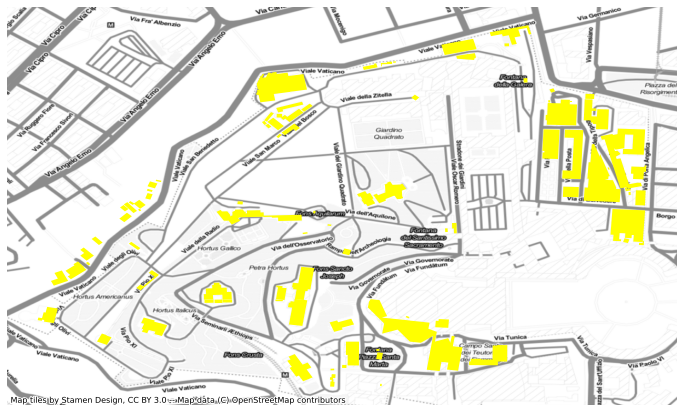

In [4]:
ax = df.plot(figsize=(12, 12), color="yellow")
contextily.add_basemap(
    ax, source=contextily.providers.Stamen.TonerLite, crs=df.crs.to_string()
)
ax.set_axis_off()

### Working with large files

The full dataset is partitioned by region. To avoid very large files for regions with many buildings, regions available as [Parquet Datasets](https://arrow.apache.org/docs/python/parquet.html#partitioned-datasets-multiple-files) consiting of multiple Parquet files. You can use libraries like [Dask](https://dask.org/) or [Apache Spark](https://spark.apache.org/) to load in the partioned data. This example uses Dask to process the data in parallel.

In [5]:
client = dask.distributed.Client()
print(client.dashboard_link)

/user/taugspurger@microsoft.com/proxy/8787/status


We'll search for items from the `Germany` region.

In [6]:
items = catalog.search(
    collections=["ms-buildings"], query={"msbuildings:region": {"eq": "Germany"}}
)
item = next(items.get_items())
item = planetary_computer.sign(item)
asset = item.assets["data"]

The asset's `href` points to the root of a Parquet datset in Azure Blob Storage. We'll use dask-geopandas to load the dataset. This gives a `dask_geopandas.GeoDataFrame` with 13 partitions.

In [7]:
germany = dask_geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
germany

,geometry,RegionName
npartitions=13,,
,geometry,category[known]
,...,...
...,...,...
,...,...
,...,...


We'll visualize the footprints for a small region outside the town of Ueckermünde. This will load and mask the data in parallel using Dask.

In [8]:
%%time
mask = shapely.geometry.box(14.11, 53.73, 14.13, 53.75)
subset = germany[germany.intersects(mask)].compute()

CPU times: user 370 ms, sys: 123 ms, total: 493 ms
Wall time: 3.91 s


In [9]:
subset.explore()

You can even work with the full global dataset, across all regions, if you'd like.

In [10]:
df_global = dask.dataframe.read_parquet(
    "az://footprints/global/2022-06-14/ml-buildings.parquet",
    storage_options=asset.extra_fields["table:storage_options"],
)
df_global

,geometry,RegionName
npartitions=3531,,
,object,category[known]
,...,...
...,...,...
,...,...
,...,...


### Next steps

This example briefly demonstrated searching the STAC catalog and loading the data with geopandas. To learn more, visit the following resources:

* Learn more about [geopandas](https://geopandas.readthedocs.io).
* Learn more about [Dask](https://dask.org/)
* Learn more about [geoparquet](https://github.com/opengeospatial/geoparquet)
* Learn more about the [Global MLBuildings Footprints](https://github.com/microsoft/GlobalMLBuildingFootprints/) project.